In [2]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Paths and categories
data_dir = '../data/processed'
categories = ['Alarm_Clock', 'Car_Horn', 'Glass_Breaking', 'Gunshot', 'Siren', 'Backdround']
metadata_csv = os.path.join(data_dir, 'processed_frames_metadata.csv')

# Preprocessing parameters
# Audio parameters
TARGET_SR = 16000
FRAME_LENGTH_SEC = 0.96
FRAME_SAMPLES = int(FRAME_LENGTH_SEC * TARGET_SR)


SILENCE_RMS_THRESHOLD = 0.015  
CLIPPING_THRESHOLD = 0.98  

CATEGORY_RMS_TARGETS = {
    'Glass_Breaking': 0.10, 
    'Alarm_Clock': 0.14,    
    'Car_Horn': 0.17,       
    'Gunshot': 0.16,       
    'Siren': 0.19,        
    'Background': 0.19       
}

In [3]:
# Load metadata
if not os.path.exists(metadata_csv):
    raise FileNotFoundError(f"{metadata_csv} not found. Run preprocessing script first.")
df = pd.read_csv(metadata_csv)
print(f"Loaded metadata: {len(df)} processed frames")
print("Metadata columns:", list(df.columns))

# Check for correct columns
required_cols = ['frame_path', 'category', 'aug_idx', 'frame_idx']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in metadata CSV: {missing_cols}")

# Derive is_augmented from aug_idx
df['is_augmented'] = df['aug_idx'] > 0

# Initialize data collection
reexploration_data = []

Loaded metadata: 8496 processed frames
Metadata columns: ['category', 'original_file', 'frame_idx', 'aug_idx', 'is_augmented', 'frame_path', 'duration_sec', 'rms']


In [4]:
def analyze_frame(frame_path, category, is_augmented, frame_idx):
    """Analyze a single frame and extract quality metrics."""
    try:
        y = np.load(frame_path)
        
        if len(y) != FRAME_SAMPLES:
            print(f"Warning: {frame_path} has incorrect length {len(y)} (expected {FRAME_SAMPLES})")
        
        duration = len(y) / TARGET_SR
        rms = np.mean(librosa.feature.rms(y=y))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        max_amp = np.max(np.abs(y))
        is_clipped = max_amp >= CLIPPING_THRESHOLD
        is_silent = rms < SILENCE_RMS_THRESHOLD
        
        # SNR estimate (kept for analysis, not used for filtering)
        noise_estimate = np.min(librosa.feature.rms(y=y)) + 1e-6
        snr = 20 * np.log10(rms / noise_estimate) if rms > 0 else 0
        
        return {
            'frame_path': frame_path,
            'category': category,
            'is_augmented': is_augmented,
            'frame_idx': frame_idx,
            'duration_sec': duration,
            'rms_mean': rms,
            'zcr_mean': zcr,
            'max_amp': max_amp,
            'is_clipped': is_clipped,
            'is_silent': is_silent,
            'snr_db': snr,
            'load_success': True
        }
    except Exception as e:
        print(f"Error loading {frame_path}: {e}")
        return {
            'frame_path': frame_path,
            'category': category,
            'is_augmented': is_augmented,
            'frame_idx': frame_idx,
            'duration_sec': None,
            'rms_mean': None,
            'zcr_mean': None,
            'max_amp': None,
            'is_clipped': False,
            'is_silent': False,
            'snr_db': None,
            'load_success': False
        }

# Analyze all frames
for _, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing processed frames"):
    info = analyze_frame(
        frame_path=row['frame_path'],
        category=row['category'],
        is_augmented=row['is_augmented'],
        frame_idx=row['frame_idx']
    )
    reexploration_data.append(info)

# Convert to DataFrame
reexp_df = pd.DataFrame(reexploration_data)
reexp_df.to_csv(os.path.join(data_dir, 'processed_audio_reexploration.csv'), index=False)
print(f"Saved re-exploration data to {data_dir}/processed_audio_reexploration.csv")


Analyzing processed frames: 100%|██████████| 8496/8496 [00:16<00:00, 517.42it/s]

Saved re-exploration data to ../data/processed/processed_audio_reexploration.csv


In [5]:
# File Integrity
failed_loads = reexp_df[~reexp_df['load_success']]
print(f"\nFailed Loads: {len(failed_loads)} frames")
if not failed_loads.empty:
    print(failed_loads[['frame_path', 'category']])


Failed Loads: 0 frames



Frame Counts per Category (Original vs Augmented):
is_augmented    False  True 
category                    
Alarm_Clock       432    864
Background        698    698
Car_Horn          740    740
Glass_Breaking    304    912
Gunshot           768    768
Siren             786    786

Total Frames per Category:
category
Siren             1572
Gunshot           1536
Car_Horn          1480
Background        1396
Alarm_Clock       1296
Glass_Breaking    1216
Name: count, dtype: int64
Total Frames: 8496
Imbalance Ratio (max/min): 1.29


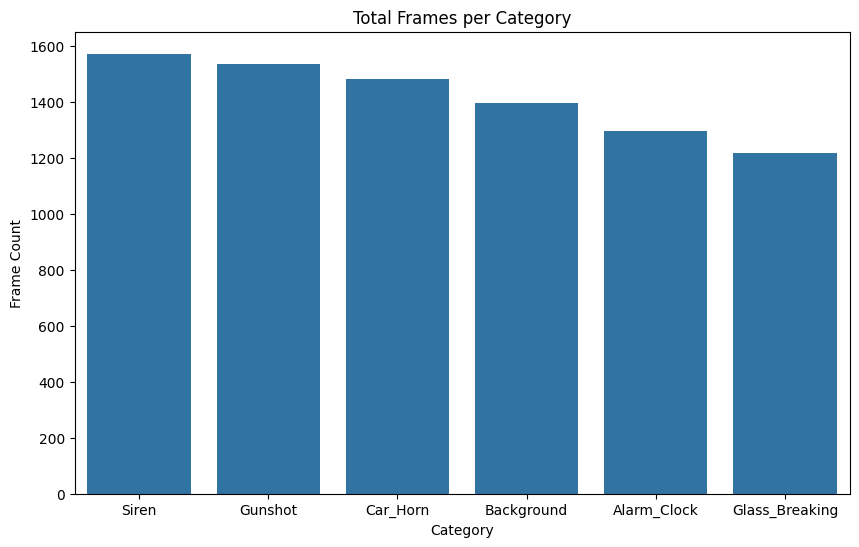

In [6]:
# Class Distribution and Balance
frame_counts = reexp_df.groupby(['category', 'is_augmented']).size().unstack(fill_value=0)
total_counts = reexp_df['category'].value_counts()
print("\nFrame Counts per Category (Original vs Augmented):")
print(frame_counts)
print("\nTotal Frames per Category:")
print(total_counts)
print(f"Total Frames: {len(reexp_df)}")
imbalance_ratio = total_counts.max() / total_counts.min() if total_counts.min() > 0 else float('inf')
print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("Warning: Dataset remains imbalanced; consider further augmentation for underrepresented classes.")

plt.figure(figsize=(10, 6))
sns.barplot(x=total_counts.index, y=total_counts.values)
plt.title('Total Frames per Category')
plt.xlabel('Category')
plt.ylabel('Frame Count')
plt.show()

In [7]:
# Frame Duration
duration_stats = reexp_df.groupby('category')['duration_sec'].agg(['min', 'max', 'mean', 'std'])
print("\nDuration Stats per Category (seconds):")
print(duration_stats)
incorrect_durations = reexp_df[reexp_df['duration_sec'] != FRAME_LENGTH_SEC]
if not incorrect_durations.empty:
    print(f"Warning: {len(incorrect_durations)} frames have incorrect duration:")
    print(incorrect_durations[['frame_path', 'category', 'duration_sec']])


Duration Stats per Category (seconds):
                 min   max  mean  std
category                             
Alarm_Clock     0.96  0.96  0.96  0.0
Background      0.96  0.96  0.96  0.0
Car_Horn        0.96  0.96  0.96  0.0
Glass_Breaking  0.96  0.96  0.96  0.0
Gunshot         0.96  0.96  0.96  0.0
Siren           0.96  0.96  0.96  0.0


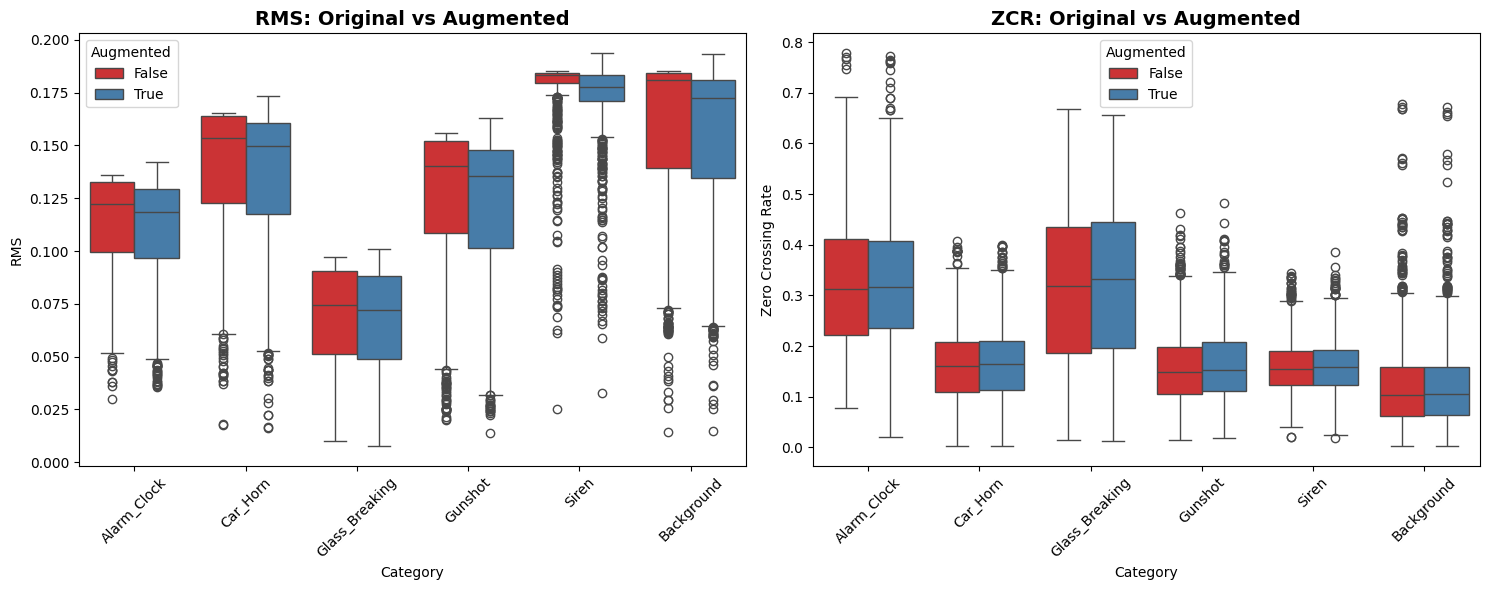

In [8]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# RMS comparison
sns.boxplot(data=reexp_df, x='category', y='rms_mean', hue='is_augmented', ax=axes[0], palette='Set1')
axes[0].set_title('RMS: Original vs Augmented', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('RMS')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Augmented')
# ZCR comparison
sns.boxplot(data=reexp_df, x='category', y='zcr_mean', hue='is_augmented', ax=axes[1], palette='Set1')
axes[1].set_title('ZCR: Original vs Augmented', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Zero Crossing Rate')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Augmented')

plt.tight_layout()
plt.show()

SNR ANALYSIS (Informational)

SNR Statistics per Category (dB):
                     mean        std       min         max
category                                                  
Alarm_Clock     27.578746  23.773513  1.089990  102.804381
Background      17.773445  25.417626  1.204429  105.484890
Car_Horn        24.746086  24.647752  1.587222  104.585840
Glass_Breaking  43.178196  29.792822  2.750176   99.768719
Gunshot         22.314640  23.338242  1.183129  103.919575
Siren           17.928961  26.050246  1.343931  105.539168

Note: Low SNR values for clean audio are often artifacts of the estimation
      method (min/max RMS ratio) and don't indicate actual noise issues.
      Siren sounds naturally produce low SNR estimates due to steady tones.


C:\Users\301364822\AppData\Local\Temp\ipykernel_15004\274131848.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=reexp_df, x='category', y='snr_db', palette='coolwarm')


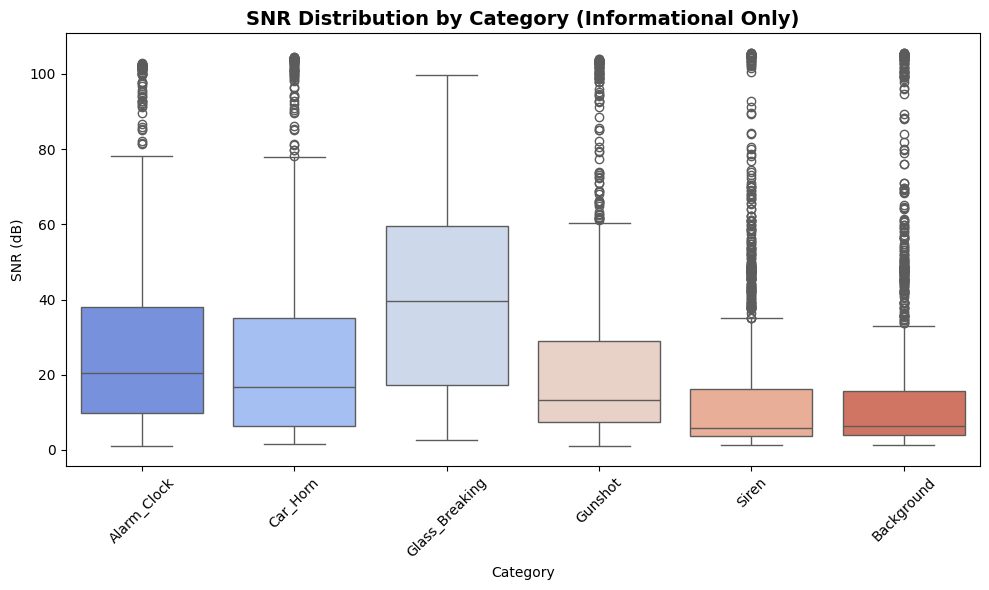

In [9]:
print("SNR ANALYSIS (Informational)")

snr_stats = reexp_df.groupby('category')['snr_db'].agg(['mean', 'std', 'min', 'max'])
print("\nSNR Statistics per Category (dB):")
print(snr_stats)

print("\nNote: Low SNR values for clean audio are often artifacts of the estimation")
print("      method (min/max RMS ratio) and don't indicate actual noise issues.")
print("      Siren sounds naturally produce low SNR estimates due to steady tones.")

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=reexp_df, x='category', y='snr_db', palette='coolwarm')
plt.title('SNR Distribution by Category (Informational Only)', fontsize=14, fontweight='bold')
plt.xlabel('Category')
plt.ylabel('SNR (dB)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Clipping Check
clipped_frames = reexp_df[reexp_df['is_clipped']]
print(f"\nClipped Frames: {len(clipped_frames)}")
if not clipped_frames.empty:
    print("Warning: Clipping detected in processed frames (should be fixed):")
    print(clipped_frames[['frame_path', 'category', 'max_amp']])


Clipped Frames: 0


In [11]:
# Silent/Low-Amplitude Frames
silent_frames = reexp_df[reexp_df['is_silent']]
print(f"\nSilent/Low-Amplitude Frames: {len(silent_frames)}")
if not silent_frames.empty:
    print("Warning: Silent/low-amplitude frames detected (should be excluded):")
    print(silent_frames[['frame_path', 'category', 'rms_mean']])


Silent/Low-Amplitude Frames: 22
                                             frame_path        category  \
2812  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Breaking   
2814  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Breaking   
2842  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Breaking   
3120  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Breaking   
3121  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Breaking   
3122  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Breaking   
3123  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Breaking   
3480  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Breaking   
3482  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Breaking   
3483  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Breaking   
3540  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Breaking   
3541  ../data/processed\Glass_Breaking\Glass_Breakin...  Glass_Brea

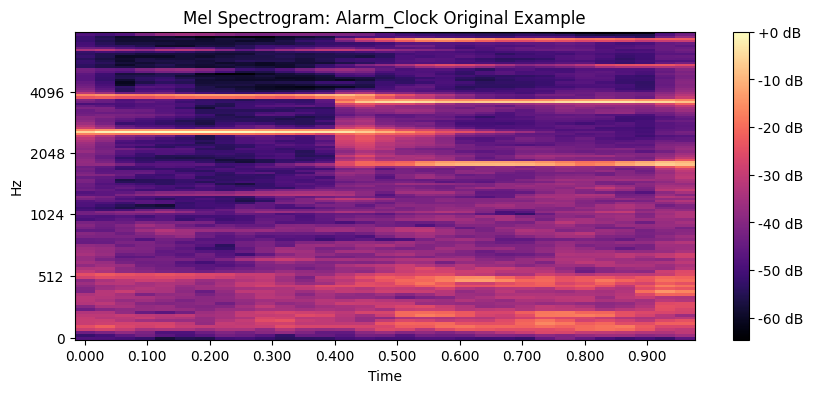

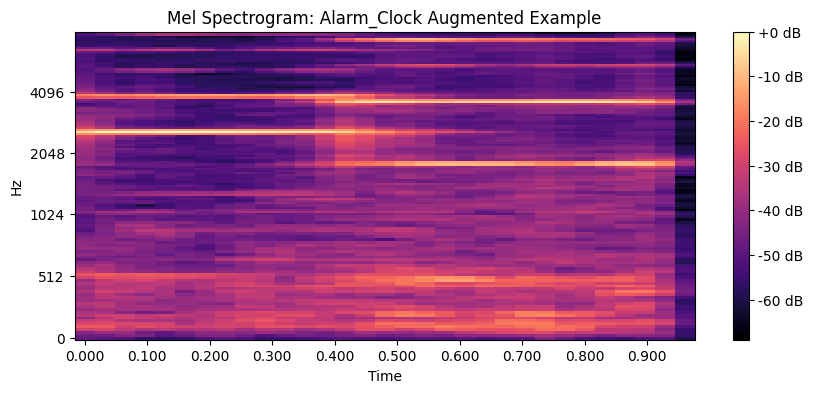

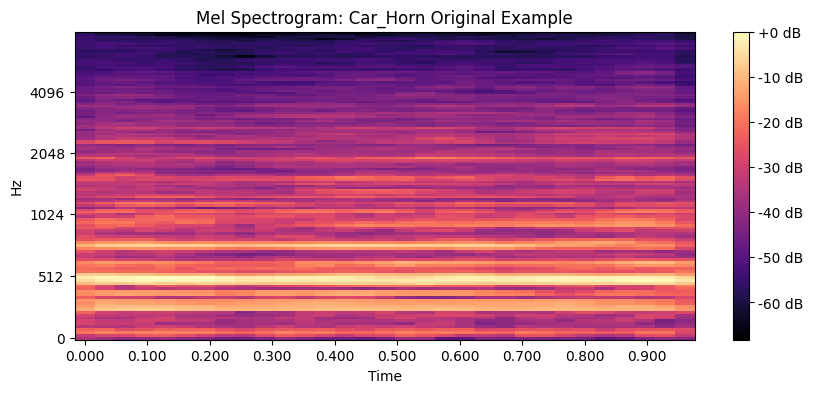

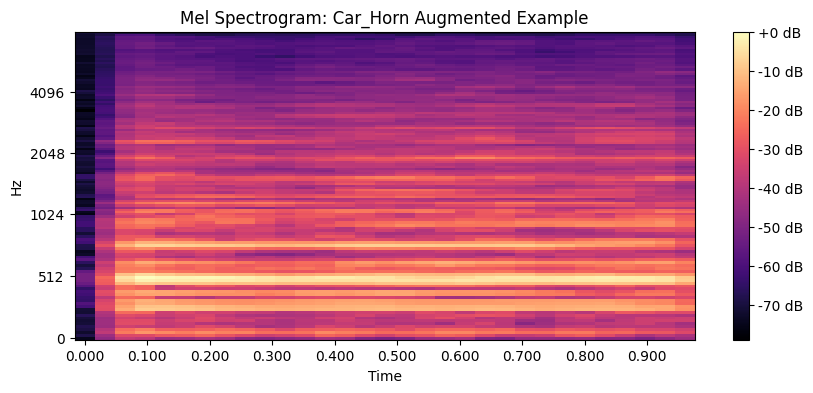

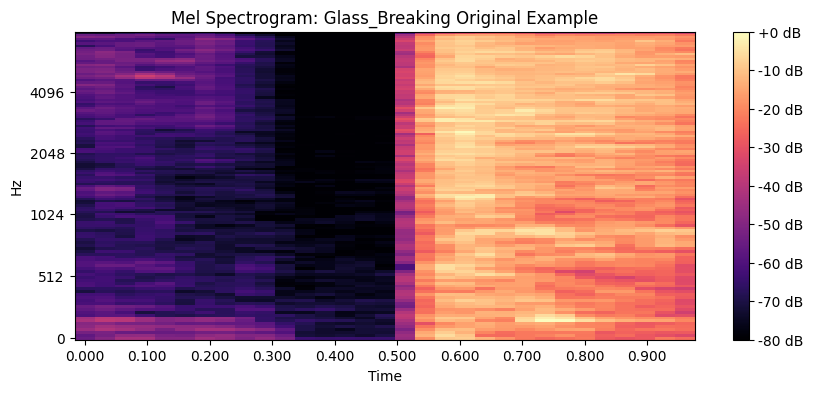

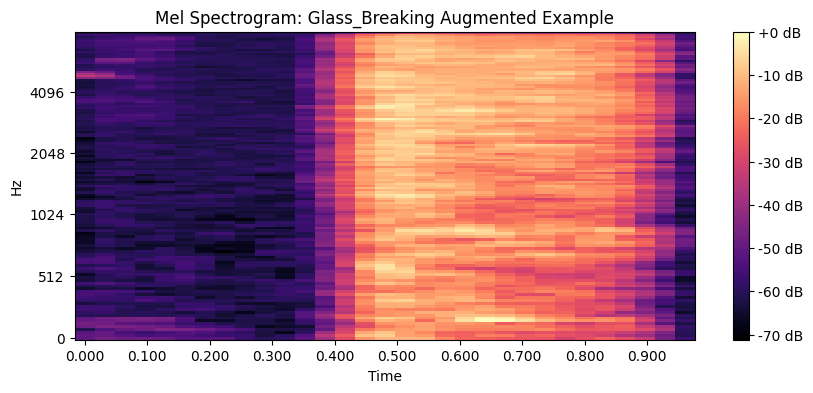

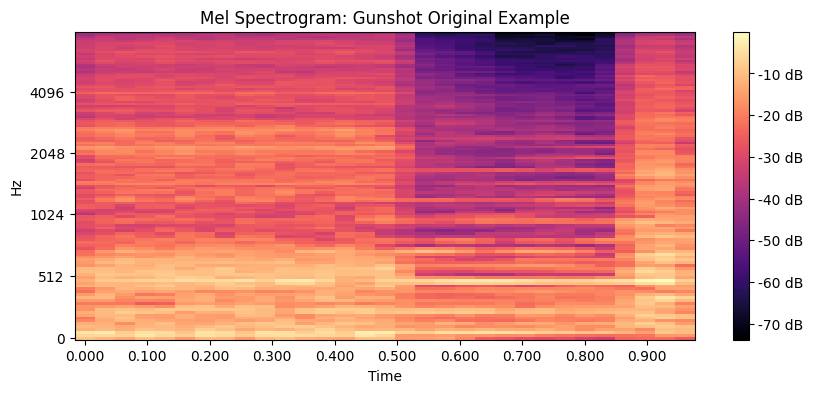

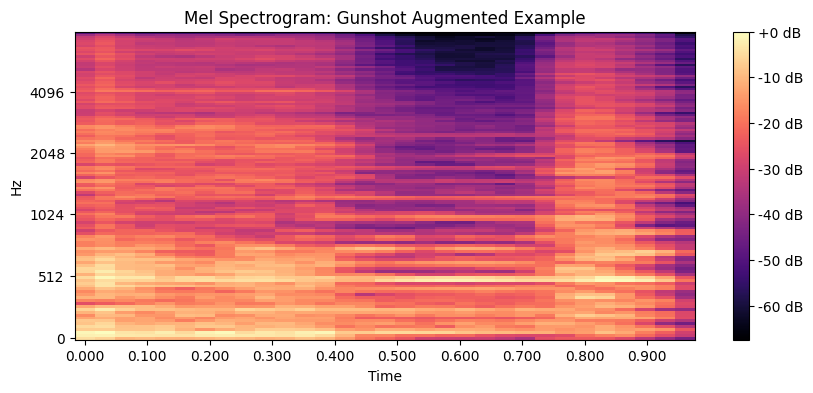

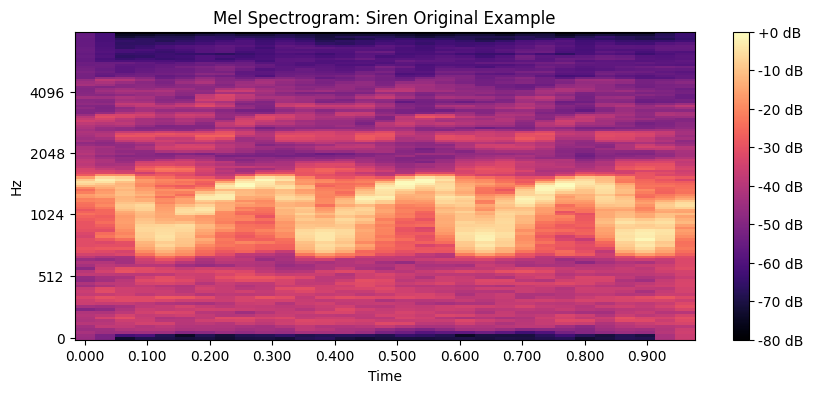

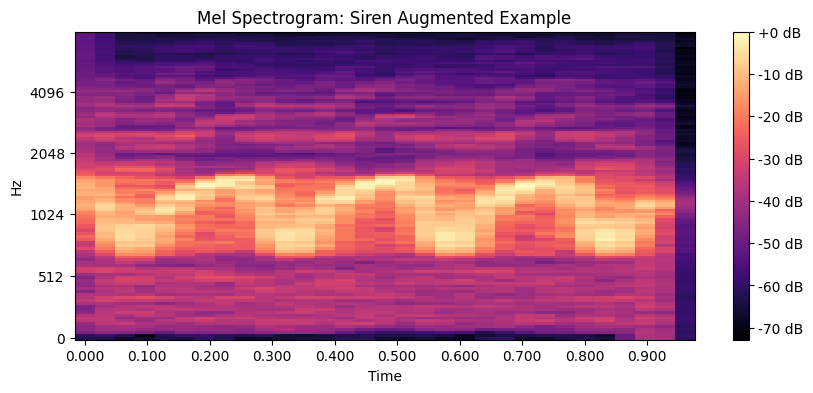

In [12]:
# Spectral Characteristics (sample spectrograms)
for category in categories:
    # Original frame
    orig_df = reexp_df[(reexp_df['category'] == category) & (reexp_df['is_augmented'] == False) & reexp_df['load_success']]
    if not orig_df.empty:
        sample_path = orig_df['frame_path'].iloc[0]
        y = np.load(sample_path)
        plt.figure(figsize=(10, 4))
        S = librosa.feature.melspectrogram(y=y, sr=TARGET_SR, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=TARGET_SR, fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram: {category} Original Example')
        plt.show()
    
    # Augmented frame (if exists)
    aug_df = reexp_df[(reexp_df['category'] == category) & (reexp_df['is_augmented'] == True) & reexp_df['load_success']]
    if not aug_df.empty:
        sample_path = aug_df['frame_path'].iloc[0]
        y = np.load(sample_path)
        plt.figure(figsize=(10, 4))
        S = librosa.feature.melspectrogram(y=y, sr=TARGET_SR, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=TARGET_SR, fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram: {category} Augmented Example')
        plt.show()

In [13]:
# Total Dataset Size
total_size_mb = sum(os.path.getsize(f) for f in glob.glob(os.path.join(data_dir, '**/*.npy'), recursive=True)) / (1024 * 1024)
print(f"\nApproximate Total Disk Size: {total_size_mb:.2f} MB")


Approximate Total Disk Size: 584.57 MB
